In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from numpy import linalg as la

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

import importlib
import gMLV_ML 
import gMLV_sim
importlib.reload(gMLV_ML);
importlib.reload(gMLV_sim);

loaded gMLV_ML
loaded gMLV_sim


In [ ]:
# some plotting functions
def plot_fit_gLV(yobs, y0, nsp, m_h, M_h):
    # plot the fit
    cols = ["red", "green", "blue", "royalblue","black"]
    #cols = [1,2,3,4,5]
    yobs_pred = odeint(gLV, y0, times, args=(nsp, mu_h, M_h)  )
    for i in range(nsp):
        plt.plot(times,yobs[:,i], color=cols[i] );
        plt.plot(times,yobs_pred[:,i], '--', color=cols[i] );

def compare_params(mu_h, mu, M_h, M):
    print("\ninferred params:")
    print("mu_hat/mu:")
    print(np.array(mu_h))
    print(np.array(mu))
    print("\nM_hat/M:")
    print(np.round(np.array(M_h),decimals=2))
    print("\n",np.array(M) )

    # plot the params
    plt.figure(figsize=(6.4*2,4.8))
    plt.subplot(1, 2, 1)
    plt.stem( np.arange(0,len(mu), dtype="int32"), np.array(mu_h), markerfmt="D" );
    plt.stem( np.arange(0,len(mu), dtype="int32"), np.array(mu), markerfmt="X" );

    plt.subplot(1, 2, 2)
    plt.stem( np.arange(0,nsp*nsp), np.array(M_h).flatten(), markerfmt="D" );
    plt.stem( np.arange(0,nsp*nsp), np.array(M).flatten(), markerfmt="X" );

## Simulate some time course data and perform ridge regression as in Stein et. al. 2013
I have coded up the Stein model and ridge regression without the perturbation term. We can include this at a later date if needed<br>
Ridge regression is designed to cause shrinkage to prevent overfitting. It isn't supposed to be used for variable selection. We should use Lasso for this, however I think we need to constrain parameters

In [ ]:
# Five species, single time course. In this example n >> p and it it is basically same as standard regression
# We have to be careful as most of these gLV models are very weakly identifiable
nsp=5;
times = np.arange(0,5,0.1)
nt = len(times)
print("nt:",nt)

yobs, y0, mu, M = gMLV_sim.sim_gLV_5(times=times, y0=[10,10,10,10,10])
    
# add some gaussian noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape )
plt.plot(times, yobs);

# linearise
X, F = gLV_ML.linearize_time_course_16S(yobs,times)
print("n,p:", nsp*F.shape[0], nsp + nsp*nsp)

# get the best lambda/alpha values on a grid via cross validation
a0, a1 = gMLV_ML.fit_alpha_cRidge(X, F, nsp=nsp, n_a0=20, n_a1=20)

# do final fit
mu_h, M_h = gMLV_ML.do_final_fit_cRidge(X, F, nsp, a0, a1)
plot_fit_gLV(yobs,y0,nsp,mu_h,M_h)

# this does the stem plots with orange crosses the actual parameters
compare_params(mu_h, mu, M_h, M)


In [ ]:
# Five species, lower number of time points, multiple time course
nsp=5;
nind = 3

times = np.arange(0,5,1)
nt = len(times)
print("nt:",nt)

ryobs = []
ry0 = []
X = np.array([], dtype=np.double).reshape(0,nsp+1)
F = np.array([], dtype=np.double).reshape(0,nsp)
for i in range(nind):
    mu = np.random.lognormal(0.01, 0.5, nsp)
    yobs, y0, mu, M = gMLV_sim.sim_gLV_5(times=times, y0=np.random.uniform(low=10,high=50,size=(5)), mu=mu)
    yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape )
    ryobs.append(yobs)
    ry0.append(y0)
    Xs, Fs = gMLV_ML.linearize_time_course_16S(yobs,times)
    #if i==0:
    X = np.vstack([X, Xs])
    F = np.vstack([F, Fs])

print("X:", X.shape)
print("F:", F.shape)
print("n,p:", nsp*F.shape[0], nsp + nsp*nsp)

## get the best lambda/alpha values on a grid via cross validation
a0, a1 = gMLV_ML.fit_alpha_cRidge(X, F, nsp=nsp, n_a0=20, n_a1=20)

mu_h, M_h = gMLV_ML.do_final_fit_cRidge(X, F, nsp, a0=a0, a1=a1)
#mu_h, M_h = gMLV_ML.do_final_fit_cRidge(X, F, nsp, a0=1, a1=0.01)
#mu_h, M_h = gMLV_ML.do_final_fit_cRidge(X, F, nsp, a0=0, a1=0)

# plot three example fits
plt.figure(figsize=(6.4*3,4.8))
plt.subplot(1, 3, 1); plot_fit_gLV(ryobs[0],ry0[0],nsp,mu_h,M_h)
plt.subplot(1, 3, 2); plot_fit_gLV(ryobs[1],ry0[1],nsp,mu_h,M_h)
plt.subplot(1, 3, 3); plot_fit_gLV(ryobs[2],ry0[2],nsp,mu_h,M_h)

compare_params(mu_h, mu, M_h, M)

# do some bootstrapping to help with interpretation of parameters
# starred parameters are considered different to zero
gMLV_ML.do_bootstrapping(X, F, nsp, a0, a1, nt, nboots=100)


## Simulate some time course data and metabolites
This model assumes metabolite production is associated with abundance:  dS/dt = alpha X <br>
Note that this model needs rethinking as it cannot handle negative productivities <br>
In this simple example we don't need to infer the time course. We just linearize and estimate the elements of alpha with Lasso<br>
Number of metabolites is 6 here

loaded gMLV_ML
nt: 50
minimum found: a/error: 0.29763514416313175 1.3771277069470502
min + se rule: a/error: 1.2742749857031335 1.3929583343282488


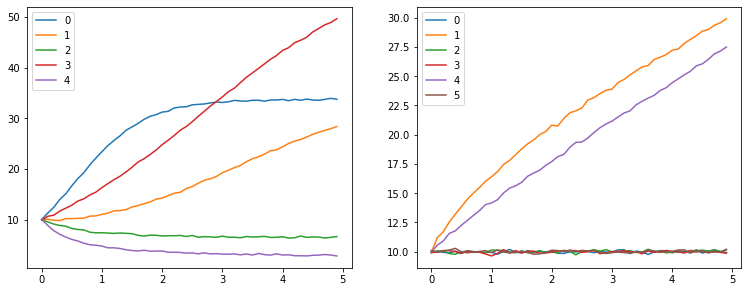

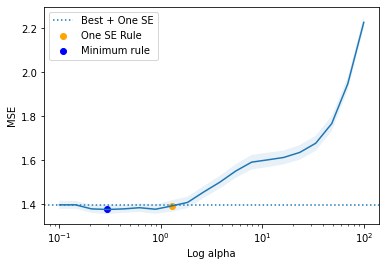


inferred params:
A_hat/A:
[[-0.   -0.   -0.   -0.   -0.  ]
 [ 0.    0.    0.09 -0.    0.84]
 [ 0.    0.    0.    0.    0.  ]
 [ 0.   -0.    0.   -0.    0.  ]
 [ 0.    0.    0.47  0.    0.  ]
 [-0.    0.   -0.    0.   -0.  ]]

 [[0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0. ]
 [0.  0.  0.5 0.  0. ]
 [0.  0.  0.  0.  0. ]]


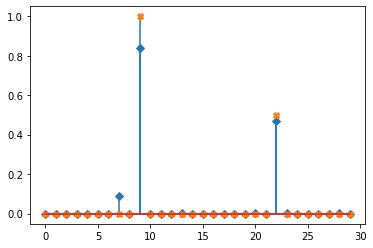

In [13]:
importlib.reload(gMLV_ML);
# Simulate some microbiota and metabolites
nsp = 5
nm = 6
times = np.arange(0,5,0.1)
nt = len(times)
print("nt:",nt)
yobs, sobs, sy0, mu, M, alpha = gMLV_sim.sim_gMLV_6by5(times, y0=[10,10,10,10,10])

# Add some noise
yobs = yobs + np.random.normal(loc=0, scale=0.1, size=yobs.shape )
#sobs = sobs + np.random.lognormal(0.01, 0.5, size=sobs.shape )
sobs = sobs + np.random.normal(loc=0, scale=0.1, size=sobs.shape )

plt.figure(figsize=(6.4*2,4.8))
plt.subplot(1, 2, 1)
plt.plot(times, yobs);
plt.legend((0,1,2,3,4))
plt.subplot(1, 2, 2)
plt.plot(times, sobs);
plt.legend((0,1,2,3,4,5));

# Linearize this problem
X, S = gMLV_ML.linearise_time_course_metabolites(sobs, yobs, times)

# get the best lambda/alpha value on a grid via cross validation
a_min, a_se = gMLV_ML.fit_alpha_lasso(X, S, n_a=20)
model = Lasso(fit_intercept=False, max_iter=10000, alpha=a_min)

# just fit based on plot
#gMLV_ML.plot_alpha_lasso(X, S, n_a=20)
#model = Lasso(fit_intercept=False, max_iter=10000, alpha=2)

model.fit(X, S);
alpha_h = model.coef_
#print("alpha_h:",alpha_h.shape)

print("\ninferred params:")
print("A_hat/A:")
print(np.round(np.array(alpha_h),decimals=2))
print("\n",np.array(alpha) )

# plot the params
# You can see Lasso does a pretty good job at picking out the metabolite, microbiota interactions
plt.figure()
plt.stem( np.arange(0,nm*nsp), np.array(alpha_h).flatten(), markerfmt="D" );
plt.stem( np.arange(0,nm*nsp), np.array(alpha).flatten(), markerfmt="X" );
